## Introduction
**Tourism in Australia is an important part of the economy in Australia, thus it's meaningful to learn more and analyze it. 
The datase from Kaggle includes 6 colounms: "Quarter", "Region", "State", "Purpose" and "Trips". "Quarter" is the data from 1998-01-01 to 2016-10-01 quartly. "Region" represents the cities in Australia, like Sydney, Adelaide,Alice Springs. "State" is the states of Australia, like South Australia, New South Wales,Northern Territory. "Purpose" is the purpose of travellers coming to Australia, including "Bussiness","Holiday" and "Other" reasons. "Trips" is the number of travellers.
To make it clearer, we chose part of the dataset as our data. We assumed the number of travellers who come Australia for holiday behaves periodically and Adelaide is one of most popular cities  for toursim. Therefore, we filtered the data and kept the data whose "Region" is "Adelaide" and "Purpose" is "Holiday" and then select the "Trips" as our objective of analysis.  
Goal: To forecast the number of travellers in New South Wales of Austrlia for holiday by analyzing the data from 1998-01-01 to 2016-10-01 quartly.** 

## Analysis

### Load and tidyverse data

In [1]:
library(tidyverse)
tourism <- read.csv("tourism.csv")%>%
filter(Purpose == "Holiday", Region== "Adelaide")%>%
select(Trips)%>%
as.ts()

n <- length(tourism)
n

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


[1] 76

### Visualization of data


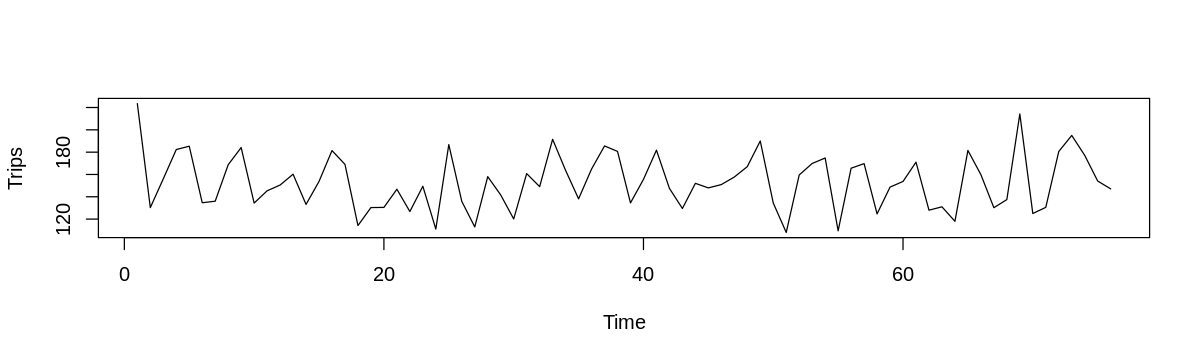

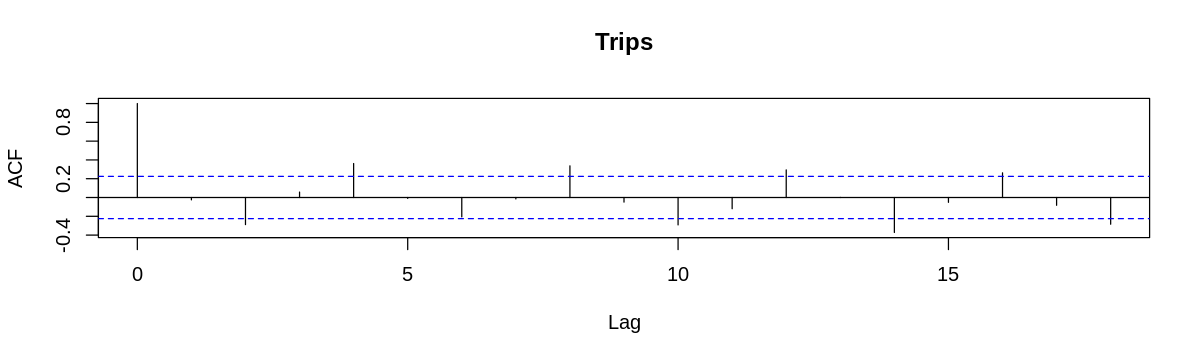

In [2]:
options(repr.plot.width = 10, repr.plot.height = 3)
plot(tourism)
acf(tourism)

**The acf decay very slowly and not decy to zero, implying the times series is not stationary. Its peak occurs every around 4 lags, which implies the acf has the period of 4 lags.
The plot of data has no trend but seems to have seasonal effect. It seems the period is 4 from the acf. To let the time seires to be stationary, we tried to difference the data be lag 4.  
The pacf of data is ......**

### Difference data to make it stationary


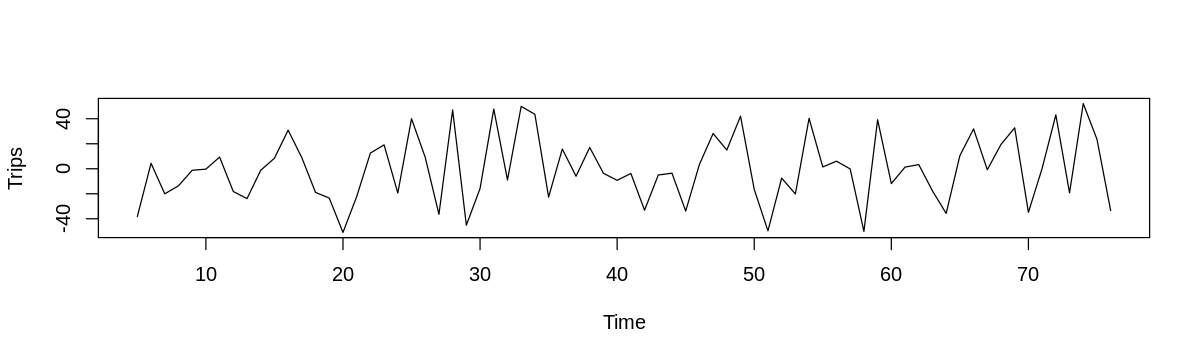

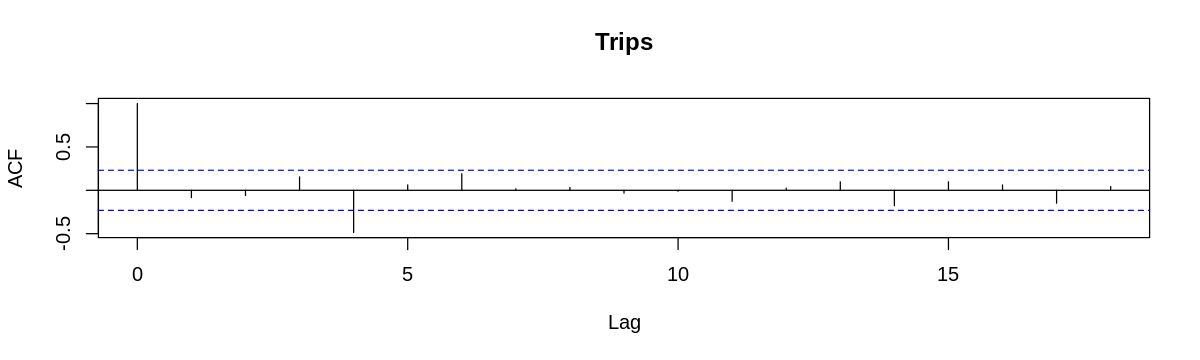

In [3]:
options(repr.plot.width = 10, repr.plot.height = 3)
diff <- diff(tourism,lag = 4) # since period is around 4
plot(diff)
acf(diff)

**From the plot of new time series, there is no trend, no seasonal effect, but there are some outstanding peaks. The acf decays very fast and most of autocorrelations close to zero, in spite of a few autocorrelations significant. The
parttern of Pacf is similar to that of acf, most of partial autocorrelations are close to 0. The
new series appear to be stationary since the acf decays to zero finally. Now, we can try to fit the processed data into models.  
AIC estimates the relative amount of information lost by a given model: the less information a model loses, the higher the quality of that model. Thus, aic can be a criteria to choose
best three models, actually, we should evaluate not only aic, but also other information, like
sigma2, log likelihood, for convenience, we only focus on aic here.**


In [4]:
# Fitting the model, choose the best three models basd on aic
aic <- c()
pq <- matrix(nrow = 28,ncol=2)
n=1
for (i in 0:6){
for (k in 0:(6-i)){
aic[n] <- arima(diff,order=c(i,0,k),include.mean = FALSE)$aic
pq[n,] <- c(i,k)
n <- n+1
}
}
best_three <- bind_cols (data.frame(pq),data.frame(aic = aic)) %>%
arrange(aic)
head(best_three,3)

X1,X2,aic
<int>,<int>,<dbl>
0,4,647.7871
0,5,649.7568
1,4,649.7576


### **From the result, we can see the aic of top 2 models are the same. The aics of three models are very close.**

In [5]:
model_1 <- arima(diff,order=c(0,0,4),include.mean = FALSE)
model_2 <- arima(diff,order=c(0,0,5),include.mean = FALSE)
model_3 <- arima(diff,order=c(1,0,4),include.mean = FALSE)
model_1
model_2
model_3


Call:
arima(x = diff, order = c(0, 0, 4), include.mean = FALSE)

Coefficients:
         ma1     ma2     ma3      ma4
      0.0804  0.1626  0.2630  -0.8192
s.e.  0.1435  0.1427  0.1518   0.1352

sigma^2 estimated as 362.8:  log likelihood = -318.89,  aic = 647.79


Call:
arima(x = diff, order = c(0, 0, 5), include.mean = FALSE)

Coefficients:
         ma1     ma2     ma3      ma4     ma5
      0.0658  0.1722  0.2671  -0.8144  0.0250
s.e.  0.1546  0.1418  0.1390   0.1283  0.1421

sigma^2 estimated as 362.8:  log likelihood = -318.88,  aic = 649.76


Call:
arima(x = diff, order = c(1, 0, 4), include.mean = FALSE)

Coefficients:
          ar1     ma1     ma2     ma3      ma4
      -0.0295  0.0957  0.1743  0.2717  -0.8069
s.e.   0.1702  0.1563  0.1467  0.1455   0.1433

sigma^2 estimated as 362.8:  log likelihood = -318.88,  aic = 649.76

**the aic of two models are the same and sigma^2 of model 2 is smaller than that of model 1. 
Now diagonase three mdoels.**

### Use tsdiag function to diagonise.

In [8]:

tsdiag(model_1)
tsdiag(model_2)
tsdiag(model_3)

ERROR: Error in value[[3L]](cond): invalid graphics state


ERROR: Error in value[[3L]](cond): invalid graphics state


ERROR: Error in plot.xy(xy.coords(x, y), type = type, ...): invalid graphics state


ERROR: Error in value[[3L]](cond): invalid graphics state


**We notice that p-values for Ljung_Box statistic at all lags are lager than significance level
for each model.
Acf of residuals at each lag is close to zero for each model.
These information show our selected three models are good.**

In [ ]:
m <- 4
train<- 1:(length(diff)-m)
trainx<- diff[train]
testx<- diff[-train]# sets up training set and test set
model_11<- arima(trainx, order = c(0, 0, 4),include.mean = F)
foremodel_1 = predict(model_11, m)#fits model to training set, uses model to␣predict test set
error_1<- sum((testx - foremodel_1$pred)^2)
model_21<- arima(trainx, order = c(0, 0, 5),include.mean = F)
foremodel_2 = predict(model_21, m)#fits model to training set, uses model to predict test set
error_2<- sum((testx - foremodel_2$pred)^2)
model_31<- arima(trainx, order = c(1, 0, 4),include.mean = F)
foremodel_3 = predict(model_31, m)#fits model to training set, uses model to predict test set
error_3 <- sum((testx - foremodel_3$pred)^2)

error_1
error_2
error_3